# Topics in Applied Micro Problem Set 1
Qingyang Han

## Question 1

The problem is

\begin{align}
    \max\limits_{c_1,c_2,\cdots,c_T} &\sum_{t=1}^{40}\beta^{t-1}u(c_t) \\
    s.t.\quad & a_{t+1}=R(a_t-c_t) \\
    & a_{T+1} \geq 0 \\
    & u(c)=\dfrac{c^{1-\gamma}}{1-\gamma}
\end{align}




We write down the problem in Bellman Equation,

\begin{align}
    &V_t(a_t) = \max\limits_{c_t} u(c_t) + \beta V_{t+1}(a_{t+1}) \\
    s.t.\quad & a_{t+1} = (a_t-c_t)R 
\end{align}

Applying FOC and the Envelope theorem, we get the Euler Equation,
\begin{align}
    u'(c_{t}) &= \beta R u'(c_{t+1}) \\
     \dfrac{c_{t+1}}{c_t} &= (\beta R)^{1/\gamma}
\end{align}

Given the intertemporal budget constraint
\begin{align}
    \sum_{t=1}^{T} c_t/R^{t-1} = a_1
\end{align}
We can solve out $c_1$ in terms of $a_1$:
\begin{align}
    c_1 = \dfrac{1-\alpha}{1-\alpha^T}a_1
\end{align}
where $\alpha=\dfrac{(\beta R)^{1/\gamma}}{R}$ is the return impatience factor.  
Therefore,
\begin{align}
    c_t &= c_1 [(\beta R)^{1/\gamma}]^{t-1} \\
        &= \dfrac{1-\alpha}{1-\alpha^T}a_1[(\beta R)^{1/\gamma}]^{t-1}
\end{align}

We can also solve the policy function $c_t(a_t)$:
\begin{align}
    c_t = \dfrac{1-\alpha}{1-\alpha^{T-t+1}} a_t
\end{align}

## Question 2

In [528]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.optimize import root_scalar
import time


In [522]:

class CRRACakeEating:
    
    def __init__(self, T=40, r=0.03, β=0.95, γ=1.5, a0=1, c_min=1e-6):
        self.T, self.r, self.β, self.γ, self.a0, self.c_min = T, r, β, γ, a0, c_min
    
    def consumption(self): # This function returns the analytical solution of c(t) and s(t) (consumption profile)
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        c = np.zeros(T)
        s = np.zeros(T)
        a = np.zeros(T+1)
        a[0] = a0
        α = (β*(1+r))**(1/γ)/(1+r)
        for i in range(T):
            c[i] = a0*(1-α)/(1-α**T)*(β*(1+r))**(i/γ)
            s[i] = a[i] - c[i]
            a[i+1] = s[i]*(1+r)
        return c,s
    
    def policy(self,t): # analytical policy function at period t
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        α = (β*(1+r))**(1/γ)/(1+r)
        c = lambda a: (   (1-α)/(1-α**(T-t+1))   ) * a
        return c
        
    
    def grid_min(self): # find the age-specific minimum grid for $a$, return a vector with length T
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        grid_min = np.zeros(T+1)
        for t in range(T):
            grid_min[-(t+2)] = grid_min[-(t+1)]/(1+r) + c_min
        return(grid_min)
    
    def grid_max(self): # find the age-specific maximum grid for $a$, return a vector with length T
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        grid_max = np.zeros(T+1)
        grid_max[0] = a0
        for t in range(T):
            grid_max[t+1] = grid_max[t]*(1+r)
        return(grid_max)
    
    def grid(self, t, N=20, method='equal_space'): # Generate the grids at age t, default number of grids is set at 20
        grid_min = self.grid_min()
        grid_max = self.grid_max()
        a_low = grid_min[t]
        a_max = grid_max[t]
        if method=='equal_space':
            grid = np.linspace(a_low, a_max, N)
        elif method=='log_space':
            loggrid = np.linspace(np.log(a_low+1), np.log(a_max+1), N)
            grid = np.exp(loggrid)-1
            
        return(grid)
    
    def Value_T(self):
        
        ## Value function at period T is V(a_T) = u(c_T)
         
        T, γ = self.T, self.γ
        """
        grid_T = self.grid(T)
        u_T = grid_T**(1-γ)/(1-γ)
        return(interp1d(grid_T, u_T, kind='linear')) 
        """
        v_T = lambda x: x**(1-γ)/(1-γ)
        return v_T
    
    def OptimalConsumption(self, v, a, a_grid_min): 
        
        # v is the value function at period t+1 
        # a is the asset at period t
        # This function solves the optimal value function as well as consumption at period t based on information at t+1
        
        γ, β, r, c_min = self.γ, self.β, self.r, self.c_min
        
        objective = lambda c: -(  c**(1-γ)/(1-γ) + β*v((a-c)*(1+r))  )
        
        result = minimize_scalar(objective, bounds=(c_min,a-a_grid_min/(1+r)), method='bounded')
        maximizer, maximum = result.x, -result.fun
        return maximizer, maximum  
    
    def ValueFunction(self,t=20,numGrid=20):
        
        # returns the value function at period t
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        
        v = self.Value_T()
        a_grid_min = 0
        #minCons = c_min
        for i in range(T-t):   
            age = T-i-1
            
            a_grid_min = self.grid_min()[age]
            a_grid_max = self.grid_max()[age]
    
            a_grid = np.linspace(a_grid_min,a_grid_max,numGrid)
            c_discrete = np.zeros_like(a_grid)
            v_discrete = np.zeros_like(a_grid)
            for j in range(len(a_grid)):
                if a_grid[j]-a_grid_min/(1+r)>c_min:
                    c_discrete[j], v_discrete[j] = self.OptimalConsumption(v,a_grid[j], a_grid_min)
                else:
                    v_discrete[j] = -1e5 
                
                # This case happens if a_grid[j] is too small, in which case we set value function at a very negative value
                   #c_discrete[j], v_discrete[j] = self.OptimalConsumption(v,c_min+a_grid[j], a_grid_min)
                    
            v = interp1d(a_grid, v_discrete, kind='linear')
            c = interp1d(a_grid, c_discrete, kind='linear')  
            
           #minCons = np.min(c_discrete)
           #maxCons = np.max(c_discrete)
        return v,c,a_grid
        
    def EulerEquation(self, t=20, numGrid=20, method='no transform'):
        
        # Using Euler Equation to solve policy function c_t(a_t)
        
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        R = 1+r
        
        mu = lambda x: x**(-γ) ## Marginal utility function
        c = lambda a: a         # initialize c, last period
        
        for i in range(T-t):
            
            age = T-i-1
            a_grid = self.grid(age, N = numGrid)
            c_discrete = np.zeros_like(a_grid)
            
            for j in range(len(a_grid)):
                f = lambda x: mu(x) - β*(1+r)*mu(c((a_grid[j]-x)*R)) 
                    # This is a decreasing function of x
                    # If x is very small, f --> positive infinity
                    # If x-->a, f --> negative infinity
                    
                
                c_discrete[j] = root_scalar(f, bracket=[1e-7, a_grid[j]], method='brentq').root
            
            # add a point c(0) = 0 so that x_new will not go below the lower bound of interpolation
            zero = np.array([0])
            c_discrete = np.concatenate((zero,c_discrete))
            a_grid = np.concatenate((zero,a_grid))
               
            c = interp1d(a_grid, c_discrete, kind='linear')
            
        return c, a_grid
      
    def EndogenousGrid(self, t=20, numGrid=10000):
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min
        
        # initialize
        a_grid = self.grid(T, N=numGrid)
        c_grid = np.copy(a_grid) # last period c=a
        for i in range(T-t):
            for j in range(len(c_grid)):
                c_grid[j] = (β*(1+r))**(-1/γ)*c_grid[j]
                a_grid[j] = c_grid[j] + a_grid[j]/(1+r)
                
        c = interp1d(a_grid, c_grid, kind='linear')
        
        return c, a_grid
      
    
    def ConsumptionProfile(self, numGrid=100, method='euler'):
        
        T, r, β, γ, a0, c_min = self.T, self.r, self.β, self.γ, self.a0, self.c_min     
           
        consumption = np.zeros(T)
        saving      = np.zeros(T)
        a = a0
        for t in range(T):
            if method=='euler':      
                c, a_grid = self.EulerEquation(t,numGrid)
            elif method=='value function':  
                v, c, a_grid = self.ValueFunction(t,numGrid)
            elif method=='endogenous grid':
                c, a_grid = self.EndogenousGrid(t, numGrid)
            
            consumption[t] = c(a)
            saving[t]      = a - consumption[t]
            a = saving[t]*(1+r)
       
        return consumption, saving
    
  
    
      
        

Notice that my value function approach interpolates $c_{t+1}(a_{t+1})$ instead of $MU(a_{t+1})$. Since the analytical solution is linear, this approach works out perfectly. 

Draw graph $c_t(a_t)$ for $t=20$:

/Users/qingyanghan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars
/Users/qingyanghan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in power


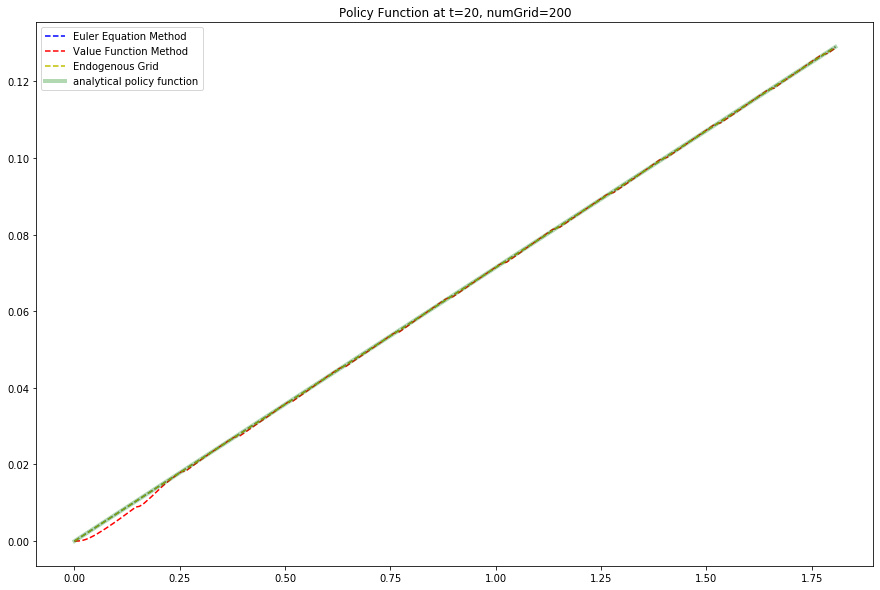

In [525]:
model = CRRACakeEating(γ=1.5)

t_range = np.array([20])
numGrid = 200

for t in t_range:
    fig, ax = plt.subplots(figsize=(15,10))
    
    c, a_grid = model.EulerEquation(t, numGrid)
    
    ax.plot(a_grid, c(a_grid), 'b--', label='Euler Equation Method')

    v, c, a_grid = model.ValueFunction(t, numGrid)
    ax.plot(a_grid, c(a_grid), 'r--', label='Value Function Method')
    
    c, xxx = model.EndogenousGrid(t, numGrid)
    ax.plot(a_grid, c(a_grid), 'y--', label='Endogenous Grid')
    
    ax.set_title('Policy Function at t='+str(t)+', numGrid='+str(numGrid))
    
    policy = model.policy(t)
    ax.plot(a_grid, policy(a_grid), 'g-', label='analytical policy function', linewidth=4, alpha=0.3)
    ax.legend()
    '''  
    v_grid, c_grid, a_grid = model.EndogenousGrid(t, numGrid)
    ax.plot(a_grid, c_grid, 'b--')
    '''
  #  print(v(a_grid))

## Question 3

Draw the simulated and analytical consumption profile

/Users/qingyanghan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars
/Users/qingyanghan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in power


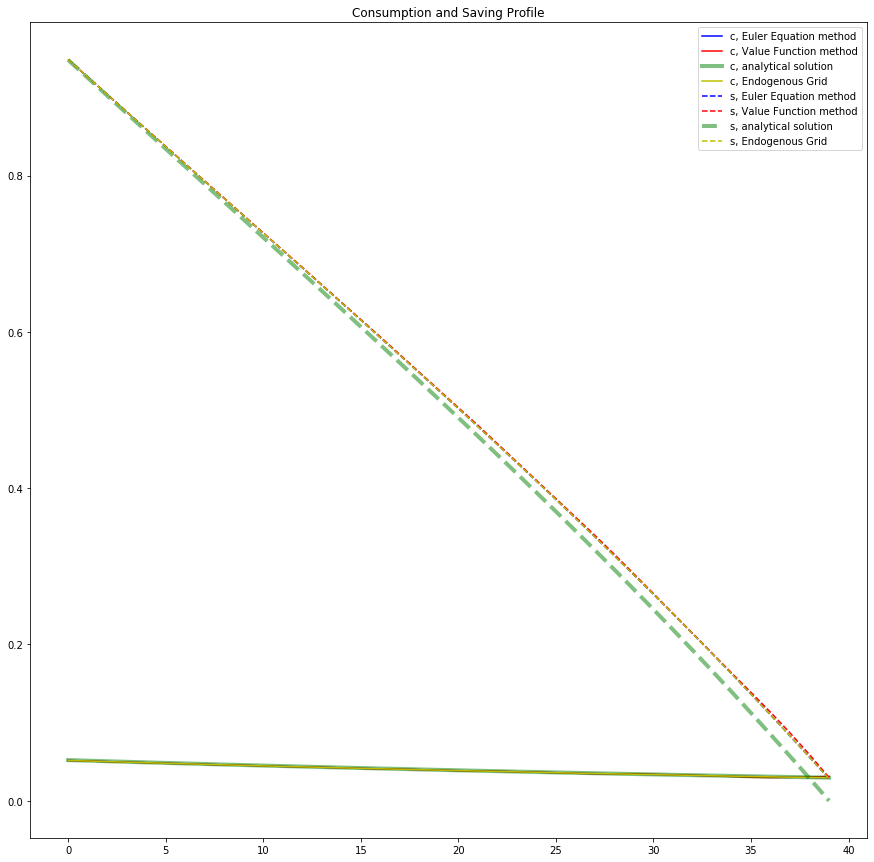

time of euler method=58.954607009887695
time of value function method=139.2335979938507
time of endogenous grid method=0.21933913230895996


In [527]:

t_range = range(model.T)

c,s = model.consumption()

start = time.time()
ConsumptionProfile_endog, saving_endog = model.ConsumptionProfile(method='endogenous grid', numGrid=200)
end = time.time()
time_endog = end-start



start = time.time()
ConsumptionProfile_euler, saving_euler = model.ConsumptionProfile(method='euler', numGrid=200)
end = time.time()
time_euler = end-start 

start = time.time()
ConsumptionProfile_valuefunction, saving_valuefunction = model.ConsumptionProfile(method='value function', numGrid=200)
end = time.time()
time_value = end-start



fig, ax = plt.subplots(figsize=(15,15))
ax.plot(t_range, ConsumptionProfile_euler,  'b-', label='c, Euler Equation method')
ax.plot(t_range, ConsumptionProfile_valuefunction,  'r-', label='c, Value Function method')
ax.plot(t_range, c, 'g-', label='c, analytical solution', alpha=0.5, linewidth=4)
ax.plot(t_range, ConsumptionProfile_endog, 'y-', label='c, Endogenous Grid')

ax.plot(t_range, saving_euler,  'b--', label='s, Euler Equation method')
ax.plot(t_range, saving_valuefunction,  'r--', label='s, Value Function method')
ax.plot(t_range, s, 'g--', label='s, analytical solution', alpha=0.5, linewidth=4)
ax.plot(t_range, saving_endog, 'y--', label='s, Endogenous Grid')

ax.legend()
ax.set(title="Consumption and Saving Profile")
plt.show()

print('time of euler method=' + str(time_euler))
print('time of value function method=' + str(time_value))
print('time of endogenous grid method={}'.format(time_endog))


### Numerical error and Runtime:

As can be seen, the endogenous grid method runs much faster than the other two methods. The value function approach is the worst both in terms of runtime and precision. 